# Sports Analytics Hackathon

### Objective:

##### 1. Predict the Winner of the series between India & Australia
##### 2. Predict the Series output proportion

### Fixtures

- 1st ODI - Hyderabad
- 2nd ODI - Nagpur
- 3rd ODI - Ranchi
- 4th ODI - Chandigarh
- 5th ODI - Delhi


### SQUAD

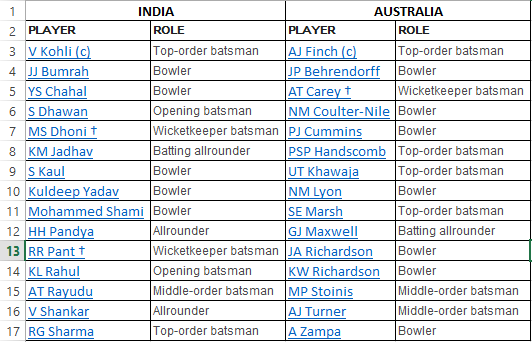

### Load Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

### Data Understanding

In [53]:
df = pd.read_csv('series_winner_data.csv')
print(df.shape)
df.head()

(116, 17)


,Team,Mat,Won,Lost,Tied,NR,WbyL,Ave,RPO,Inns,HS,LS,Start Date,Winner,Tournament,Opposition,Venue
0,Australia,5,1,4,0,0,0.25,46.32,5.53,5,288,-,16-Jan-09,South Africa,ODI Series,South Africa,Australia
1,India,5,4,1,0,0,4,28.62,5.38,5,320,216,28-Jan-09,India,ODI Series,Sri Lanka,Sri Lanka
2,Australia,4,2,2,0,0,1,30.70,4.69,4,269,269,01-Feb-09,drawn,ODI Series,New Zealand,Australia
3,India,4,3,1,0,0,3,35.26,6.39,4,334,334,03-Mar-09,India,ODI Series,New Zealand,New Zealand
4,Australia,5,2,3,0,0,0.666,32.54,5.54,5,317,145,03-Apr-09,South Africa,ODI Series,South Africa,South Africa


In [54]:
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Year'] = df['Start Date'].dt.year

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 18 columns):
Team          116 non-null object
Mat           116 non-null int64
Won           116 non-null int64
Lost          116 non-null int64
Tied          116 non-null int64
NR            116 non-null int64
WbyL          116 non-null object
Ave           116 non-null float64
RPO           116 non-null float64
Inns          116 non-null int64
HS            116 non-null int64
LS            116 non-null object
Start Date    116 non-null datetime64[ns]
Winner        116 non-null object
Tournament    116 non-null object
Opposition    88 non-null object
Venue         116 non-null object
Year          116 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(8), object(7)
memory usage: 16.4+ KB


In [56]:
ranking_df = pd.read_csv('team_ranking.csv')
print(ranking_df.shape)
ranking_df.head()

(15, 4)


,Team,Matches,Points,Rating
0,England,55,6918,126
1,India,66,8058,122
2,New Zealand,53,5930,112
3,South Africa,50,5545,111
4,Pakistan,48,4872,102


In [57]:
ranking_df = ranking_df.append({'Team':'Misc', 'Matches':ranking_df['Matches'].mean(), 'Points': ranking_df['Points'].mean(),
                   'Rating':ranking_df['Rating'].mean()}, ignore_index=True)

### Data Preprecessing

In [58]:
for col in df.columns:
    print(col)
    print(df[col].unique(), '\n')

Team
['Australia' 'India'] 

Mat
[ 5  4  3  1  7  2  6  9 11  8] 

Won
[1 4 2 3 6 5 0 7] 

Lost
[4 1 2 3 0 5] 

Tied
[0 1] 

NR
[0 1] 

WbyL
['0.25' '4' '1' '3' '0.666' '1.5' '2' '-' '6' '0.5' '0.333' '0' '7' '1.2'
 '0.75' '5'] 

Ave
[46.32 28.62 30.7  35.26 32.54 25.64 36.68 15.6  25.   28.26 26.08 22.68
 37.75 40.87 39.03 20.02 20.68 41.36 26.76 47.52 25.21 19.2  28.58 24.47
 96.33 25.95 25.81 26.95 27.25 29.86 27.46 20.6  40.77 31.97 22.88 41.68
 25.11 29.72 28.79 28.25 37.96 38.94 41.71 25.42 61.64 37.66 34.55 26.45
 23.57 33.   20.98 22.4  37.28 26.15 20.73 16.2  26.18 45.06 46.94 33.17
 63.8  31.9  45.62 28.   17.36 33.29 24.   20.23 31.03 27.1  26.94 44.83
 44.71 20.46 22.75 16.88 31.12 24.18 15.7  28.02 42.85 53.1  30.88 24.84
 14.37 23.91 19.8  54.39 22.95 22.16 30.97 45.08 31.5  38.75 60.   22.26
 23.7  42.25 27.61 36.18 22.22 45.97 44.73 24.62 26.88 38.72 34.   22.47] 

RPO
[5.53 5.38 4.69 6.39 5.54 4.28 6.37 3.94 4.86 5.13 4.56 5.01 5.34 6.54
 5.3  4.5  4.88 5.39 4.99 4.57 

In [59]:
def processResult(row):
    if row['Team'] == 'India' and row['Winner'] == 'India':
        return 'WIN'
    elif row['Team'] == 'Australia' and row['Winner'] == 'Australia':
        return 'WIN'
    elif row['Winner'] == 'drawn':
        return 'DRAW'
    else:
        return 'LOSS'

In [60]:
df['Result'] = df.apply(processResult, axis=1)

In [61]:
df['Win_diff'] = df['Won'] - df['Lost']

In [62]:
def processVenueCondition(row):
    if row['Team'] == row['Venue']:
        return 'HOME'
    else:
        return 'AWAY'

In [63]:
df['Venue_Condition'] = df.apply(processVenueCondition, axis=1)

In [64]:
# Fill na values of Opposition with Misc and mean ranking
df['Opposition'].fillna('Misc', inplace=True)

In [65]:
df['Team_Rating'] = df['Team'].apply( lambda x : int(ranking_df.loc[ ranking_df['Team'] == x ]['Rating']))
df['Opp_Rating'] = df['Opposition'].apply( lambda x : ranking_df['Rating'][0] if str(x) == 'nan' else int(ranking_df.loc[ ranking_df['Team'] == x ]['Rating']))
df['Rating_diff'] = df['Team_Rating'] - df['Opp_Rating']

In [66]:
encode = {
    
    'Year' : {2009:'2009-2010', 2010:'2009-2010', 2011:'2011-2012', 2012:'2011-2012', 2013:'2013-2014', 
              2014:'2013-2014', 2015:'2015-2016', 2016:'2015-2016', 2017:'2017-2019', 2018:'2017-2019', 
              2019:'2017-2019'}
}

df.replace(encode, inplace=True)

### Feature Engineering and Mean Encoding

In [67]:
mean_group_df = df.groupby(['Team','Opposition','Year']).agg({'Win_diff':'mean','Ave':'mean','RPO':'mean'}).add_prefix('mean_').reset_index()
mean_group_df = mean_group_df.merge(df.groupby(['Team','Opposition','Year']).agg({'Mat':'sum','Won':'sum','Lost':'sum','Tied':'sum'}).add_prefix('total_H2H_').reset_index())
mean_group_df = mean_group_df.merge(df.groupby(['Team','Year']).agg({'Mat':'sum','Won':'sum','Lost':'sum','Tied':'sum'}).add_prefix('total_HT_year_').reset_index(),on=['Team','Year'])
mean_group_df = mean_group_df.merge(df.groupby(['Opposition','Year']).agg({'Mat':'sum','Won':'sum','Lost':'sum','Tied':'sum'}).add_prefix('total_AT_year_').reset_index(),on=['Opposition','Year'])

In [68]:
mean_group_df['Won_Ratio_H2H'] = mean_group_df['total_H2H_Won'] / mean_group_df['total_H2H_Mat']
mean_group_df['Lost_Ratio_H2H'] = mean_group_df['total_H2H_Lost'] / mean_group_df['total_H2H_Mat']
mean_group_df['Tied_Ratio_H2H'] = mean_group_df['total_H2H_Tied'] / mean_group_df['total_H2H_Mat']

mean_group_df['Won_Ratio_HT_Year'] = mean_group_df['total_HT_year_Won'] / mean_group_df['total_HT_year_Mat']
mean_group_df['Lost_Ratio_HT_Year'] = mean_group_df['total_HT_year_Lost'] / mean_group_df['total_HT_year_Mat']
mean_group_df['Tied_Ratio_HT_Year'] = mean_group_df['total_HT_year_Tied'] / mean_group_df['total_HT_year_Mat']

mean_group_df['Won_Ratio_AT_Year'] = mean_group_df['total_AT_year_Won'] / mean_group_df['total_AT_year_Mat']
mean_group_df['Lost_Ratio_AT_Year'] = mean_group_df['total_AT_year_Lost'] / mean_group_df['total_AT_year_Mat']
mean_group_df['Tied_Ratio_AT_Year'] = mean_group_df['total_AT_year_Tied'] / mean_group_df['total_AT_year_Mat']

In [69]:
mean_group_df.sample(10)

,Team,Opposition,Year,mean_Win_diff,mean_Ave,mean_RPO,total_H2H_Mat,total_H2H_Won,total_H2H_Lost,total_H2H_Tied,...,total_AT_year_Tied,Won_Ratio_H2H,Lost_Ratio_H2H,Tied_Ratio_H2H,Won_Ratio_HT_Year,Lost_Ratio_HT_Year,Tied_Ratio_HT_Year,Won_Ratio_AT_Year,Lost_Ratio_AT_Year,Tied_Ratio_AT_Year
23,Australia,South Africa,2009-2010,-2.0,39.43,5.535,10,3,7,0,...,0,0.300000,0.700000,0.0,0.639344,0.360656,0.000000,0.384615,0.615385,0.000000
55,Australia,Misc,2017-2019,-1.0,60.00,5.950,1,0,1,0,...,1,0.000000,1.000000,0.0,0.275862,0.724138,0.000000,0.666667,0.250000,0.083333
65,India,New Zealand,2013-2014,-4.0,45.62,6.070,5,0,4,1,...,1,0.000000,0.800000,0.2,0.660377,0.320755,0.018868,0.000000,0.800000,0.200000
36,Australia,South Africa,2013-2014,3.0,30.70,5.570,5,4,1,0,...,0,0.800000,0.200000,0.0,0.641026,0.333333,0.000000,0.571429,0.428571,0.000000
61,India,South Africa,2017-2019,4.0,22.22,4.970,6,5,1,0,...,0,0.833333,0.166667,0.0,0.732143,0.232143,0.035714,0.666667,0.333333,0.000000
38,Australia,Sri Lanka,2013-2014,0.0,23.57,4.430,4,2,2,0,...,0,0.500000,0.500000,0.0,0.641026,0.333333,0.000000,0.777778,0.222222,0.000000
17,Australia,Misc,2009-2010,4.0,26.08,4.560,4,4,0,0,...,0,1.000000,0.000000,0.0,0.639344,0.360656,0.000000,0.592593,0.407407,0.000000
29,Australia,England,2013-2014,2.0,29.04,5.170,8,6,2,0,...,0,0.750000,0.250000,0.0,0.641026,0.333333,0.000000,0.705882,0.294118,0.000000
34,Australia,Pakistan,2013-2014,3.0,20.23,4.460,3,3,0,0,...,0,1.000000,0.000000,0.0,0.641026,0.333333,0.000000,1.000000,0.000000,0.000000
15,Australia,India,2009-2010,0.5,67.04,5.560,7,4,3,0,...,0,0.571429,0.428571,0.0,0.639344,0.360656,0.000000,0.571429,0.428571,0.000000


In [70]:
df = df.merge(mean_group_df, on=['Team','Opposition','Year'], how='left')

In [71]:
df.head()

,Team,Mat,Won,Lost,Tied,NR,WbyL,Ave,RPO,Inns,...,total_AT_year_Tied,Won_Ratio_H2H,Lost_Ratio_H2H,Tied_Ratio_H2H,Won_Ratio_HT_Year,Lost_Ratio_HT_Year,Tied_Ratio_HT_Year,Won_Ratio_AT_Year,Lost_Ratio_AT_Year,Tied_Ratio_AT_Year
0,Australia,5,1,4,0,0,0.25,46.32,5.53,5,...,0,0.300000,0.700000,0.0,0.639344,0.360656,0.0,0.384615,0.615385,0.0
1,India,5,4,1,0,0,4,28.62,5.38,5,...,0,0.777778,0.222222,0.0,0.629630,0.370370,0.0,0.666667,0.333333,0.0
2,Australia,4,2,2,0,0,1,30.70,4.69,4,...,0,0.555556,0.444444,0.0,0.639344,0.360656,0.0,0.722222,0.277778,0.0
3,India,4,3,1,0,0,3,35.26,6.39,4,...,0,0.888889,0.111111,0.0,0.629630,0.370370,0.0,0.722222,0.277778,0.0
4,Australia,5,2,3,0,0,0.666,32.54,5.54,5,...,0,0.300000,0.700000,0.0,0.639344,0.360656,0.0,0.384615,0.615385,0.0


### EDA

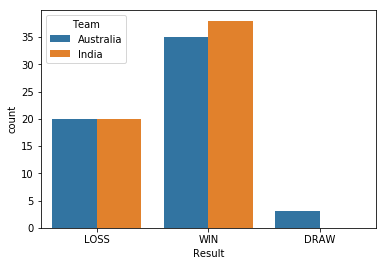

In [72]:
sns.countplot(x='Result', hue='Team', data=df)

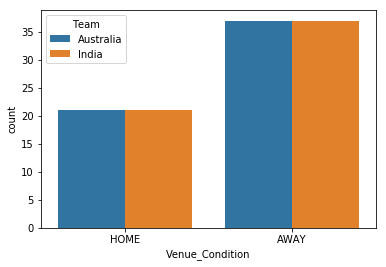

In [73]:
sns.countplot(x='Venue_Condition', hue='Team', data=df)

Text(0.5, 1.0, 'Australia Win/Loss Distribution')

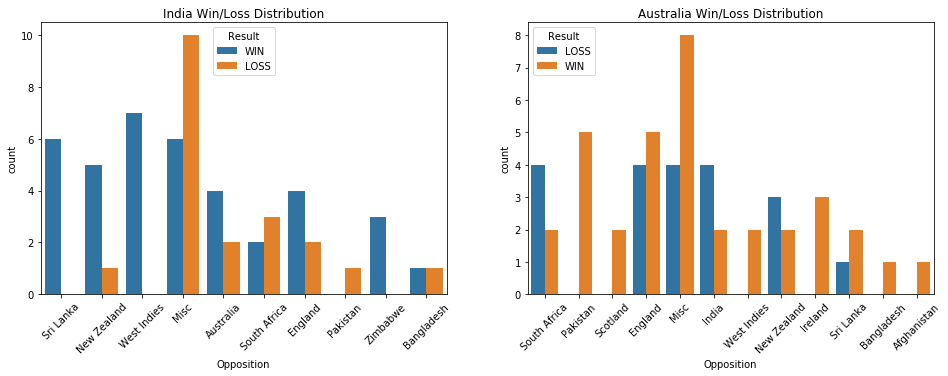

In [74]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.countplot(x='Opposition', hue='Result', data=df.loc[ (df['Team']=='India') & (df['Result'].isin(['WIN','LOSS'])) ])
plt.xticks(rotation=45)
plt.title('India Win/Loss Distribution')

plt.subplot(1,2,2)
sns.countplot(x='Opposition', hue='Result', data=df.loc[ (df['Team']=='Australia') & (df['Result'].isin(['WIN','LOSS'])) ])
plt.xticks(rotation=45)
plt.title('Australia Win/Loss Distribution')

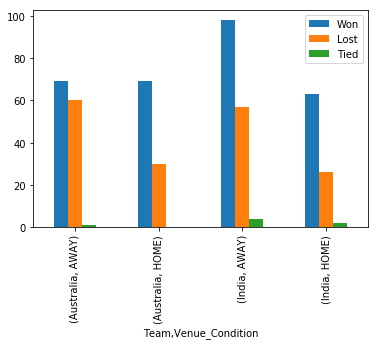

In [75]:
df.groupby(['Team','Venue_Condition']).agg({'Won':'sum', 'Lost':'sum', 'Tied':'sum'}).plot(kind='bar')

## 1. Predict the Winner of the series between India & Australia

### Data Preparation for Modeling

In [76]:
master_df = df[['Team','Opposition','Venue_Condition','Mat','Won','Lost','Tied','Rating_diff','mean_Win_diff','mean_Ave','mean_RPO',
                'Won_Ratio_H2H','Lost_Ratio_H2H','Tied_Ratio_H2H','Won_Ratio_HT_Year','Lost_Ratio_HT_Year',
                'Tied_Ratio_HT_Year','Won_Ratio_AT_Year','Lost_Ratio_AT_Year','Tied_Ratio_AT_Year','Result']]
master_df.head()

,Team,Opposition,Venue_Condition,Mat,Won,Lost,Tied,Rating_diff,mean_Win_diff,mean_Ave,...,Won_Ratio_H2H,Lost_Ratio_H2H,Tied_Ratio_H2H,Won_Ratio_HT_Year,Lost_Ratio_HT_Year,Tied_Ratio_HT_Year,Won_Ratio_AT_Year,Lost_Ratio_AT_Year,Tied_Ratio_AT_Year,Result
0,Australia,South Africa,HOME,5,1,4,0,-11,-2.0,39.430,...,0.300000,0.700000,0.0,0.639344,0.360656,0.0,0.384615,0.615385,0.0,LOSS
1,India,Sri Lanka,AWAY,5,4,1,0,44,2.5,34.745,...,0.777778,0.222222,0.0,0.629630,0.370370,0.0,0.666667,0.333333,0.0,WIN
2,Australia,New Zealand,HOME,4,2,2,0,-12,0.5,28.730,...,0.555556,0.444444,0.0,0.639344,0.360656,0.0,0.722222,0.277778,0.0,DRAW
3,India,New Zealand,AWAY,4,3,1,0,10,3.5,30.535,...,0.888889,0.111111,0.0,0.629630,0.370370,0.0,0.722222,0.277778,0.0,WIN
4,Australia,South Africa,AWAY,5,2,3,0,-11,-2.0,39.430,...,0.300000,0.700000,0.0,0.639344,0.360656,0.0,0.384615,0.615385,0.0,LOSS


In [77]:
master_df['Result'].unique()

array(['LOSS', 'WIN', 'DRAW'], dtype=object)

In [78]:
encode = {
    
    'Team' : {'India':0, 'Australia':1},
    'Opposition' : { 'India':0, 'Australia':1, 'South Africa':2, 'Sri Lanka':3, 'New Zealand':4, 'Pakistan':5, 'West Indies':6,
                     'Scotland':7, 'England':8, 'Ireland':9, 'Bangladesh':10, 'Afghanistan':11, 'Zimbabwe':12, 'Misc':13 },
    'Venue_Condition': {'HOME':0, 'AWAY':1},
    'Result' : {'LOSS':0, 'WIN':1, 'DRAW':2}
    
}

master_df.replace(encode, inplace=True)

In [79]:
master_df.head()

,Team,Opposition,Venue_Condition,Mat,Won,Lost,Tied,Rating_diff,mean_Win_diff,mean_Ave,...,Won_Ratio_H2H,Lost_Ratio_H2H,Tied_Ratio_H2H,Won_Ratio_HT_Year,Lost_Ratio_HT_Year,Tied_Ratio_HT_Year,Won_Ratio_AT_Year,Lost_Ratio_AT_Year,Tied_Ratio_AT_Year,Result
0,1,2,0,5,1,4,0,-11,-2.0,39.430,...,0.300000,0.700000,0.0,0.639344,0.360656,0.0,0.384615,0.615385,0.0,0
1,0,3,1,5,4,1,0,44,2.5,34.745,...,0.777778,0.222222,0.0,0.629630,0.370370,0.0,0.666667,0.333333,0.0,1
2,1,4,0,4,2,2,0,-12,0.5,28.730,...,0.555556,0.444444,0.0,0.639344,0.360656,0.0,0.722222,0.277778,0.0,2
3,0,4,1,4,3,1,0,10,3.5,30.535,...,0.888889,0.111111,0.0,0.629630,0.370370,0.0,0.722222,0.277778,0.0,1
4,1,2,1,5,2,3,0,-11,-2.0,39.430,...,0.300000,0.700000,0.0,0.639344,0.360656,0.0,0.384615,0.615385,0.0,0


In [80]:
predictor_var = ['Venue_Condition','Rating_diff','mean_Win_diff','mean_Ave','mean_RPO',
                 'Won_Ratio_H2H','Lost_Ratio_H2H','Tied_Ratio_H2H','Won_Ratio_HT_Year','Lost_Ratio_HT_Year',
                 'Tied_Ratio_HT_Year','Won_Ratio_AT_Year','Lost_Ratio_AT_Year','Tied_Ratio_AT_Year']
response_var = ['Result']

X = master_df[predictor_var]
Y = master_df[response_var]

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0 )

In [82]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

### Logistic Regression(Lasso)

In [83]:
param_grid = dict(C=(0.0001,0.001,0.01,0.05,0.1,0.5,1))
log_reg1 = GridSearchCV( LogisticRegression(penalty="l1", class_weight="balanced"), param_grid = param_grid, scoring = "accuracy")
log_reg1.fit(X_train,Y_train)
print('Best Params:',log_reg1.best_params_)
print('Accuracy:', round(np.mean(cross_val_score(log_reg1.best_estimator_ , X_train, Y_train, cv=k_fold, scoring="accuracy")),2))

Best Params: {'C': 1}
Accuracy: 0.82


### Logistic Regression(Ridge)

In [84]:
param_grid = dict(C=(0.0001,0.001,0.01,0.05,0.1,0.5,1))
log_reg2 = GridSearchCV( LogisticRegression(penalty="l2", class_weight="balanced"), param_grid = param_grid, scoring = "accuracy")
log_reg2.fit(X_train,Y_train)
print('Best Params:',log_reg2.best_params_)
print('Accuracy:', round(np.mean(cross_val_score(log_reg2.best_estimator_ , X_train, Y_train, cv=k_fold, scoring="accuracy")),2))

Best Params: {'C': 0.5}
Accuracy: 0.84


### SVM_Kernel

In [85]:
param_grid = dict(C=(0.001,0.01,0.1,0.5,1,2),gamma=(0.001,0.01,0.1,0.5,1,2))
svm_krnl = GridSearchCV(SVC(kernel="rbf",class_weight="balanced", random_state=0),param_grid=param_grid,scoring="accuracy")
svm_krnl.fit(X_train,Y_train)
print('Best Params:',svm_krnl.best_params_)
print('Accuracy:', round(np.mean(cross_val_score(svm_krnl.best_estimator_ , X_train, Y_train, cv=k_fold, scoring="accuracy")),2))

Best Params: {'C': 2, 'gamma': 0.1}
Accuracy: 0.7


### SVM_Linear

In [86]:
param_grid = dict(C=(0.001,0.01,0.1,0.5,1,2))
svm_lnr = GridSearchCV(LinearSVC(random_state=0, class_weight="balanced"), param_grid=param_grid, scoring="accuracy")
svm_lnr.fit(X_train,Y_train)
print('Best Params:',svm_lnr.best_params_)
print('Accuracy:', round(np.mean(cross_val_score(svm_lnr.best_estimator_ , X_train, Y_train, cv=k_fold, scoring="accuracy")),2))

Best Params: {'C': 0.01}
Accuracy: 0.82


### KNN

In [87]:
param_grid = dict(n_neighbors=np.arange(10,50),weights=("uniform","distance"),p=(1,2))
knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, scoring="accuracy")
knn_clf.fit(X_train,Y_train)
print('Best Params:',knn_clf.best_params_)
print('Accuracy:', round(np.mean(cross_val_score(knn_clf.best_estimator_ , X_train, Y_train, cv=k_fold, scoring="accuracy")),2))

Best Params: {'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}
Accuracy: 0.73


### Random Forest

In [88]:
#param_grid = dict(n_estimators = np.arange(100,500,100), max_depth=np.arange(3,10,2), min_samples_leaf=np.arange(1,6,2), 
#                  min_samples_split=np.arange(2,8,2), max_leaf_nodes=np.arange(50,100,10))
#rf_clf = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=param_grid, scoring="accuracy", n_jobs=-1)
rf_clf = RandomForestClassifier(max_depth= 5, max_leaf_nodes= 50, min_samples_leaf= 1, min_samples_split= 2, 
                               n_estimators= 50, class_weight="balanced", random_state=0)
rf_clf.fit(X_train,Y_train)
rf_clf.score(X_train,Y_train)
#print('Best Params:',rf_clf.best_params_)
#print('Accuracy:', round(np.mean(cross_val_score(rf_clf.best_estimator_ , X_train, Y_train, cv=k_fold, scoring="accuracy")),2))

0.9347826086956522

### XGBoost

In [89]:
#param_grid = dict(n_estimators=np.arange(100,600,100), max_depth=np.arange(6,12), learning_rate=(0.0001,0.001,0.01,0.1))
#xgb_clf = GridSearchCV(xgb.XGBClassifier(random_state=0), param_grid=param_grid, scoring="accuracy", n_jobs=-1)
xgb_clf = xgb.XGBClassifier(random_state=0,learning_rate= 0.001, max_depth= 6, n_estimators= 300)
xgb_clf.fit(X_train,Y_train)
xgb_clf.score(X_train,Y_train)
#print('Best Params:',xgb_clf.best_params_)
#print('Accuracy:', round(np.mean(cross_val_score(xgb_clf.best_estimator_ , X_train, Y_train, cv=k_fold, scoring="accuracy")),2))

0.9239130434782609

### Ensemble Model

In [90]:
eclf = VotingClassifier(estimators=[
                                        ('Log_Lasso',log_reg1.best_estimator_), 
                                        ('Log_Ridge',log_reg2.best_estimator_),
                                        #('SVM_Kernel', svm_krnl.best_estimator_),
                                        #('SVM_Linear', svm_lnr.best_estimator_),
                                        ('KNN', knn_clf.best_estimator_), 
                                        ('RF', rf_clf), 
                                        ('XGB', xgb_clf)
                                   ], voting='soft')

eclf.fit(X_train, Y_train)
Y_pred = eclf.predict(X_test)
confusion_matrix(Y_test, Y_pred)

array([[ 6,  3,  0],
       [ 3, 10,  0],
       [ 0,  2,  0]], dtype=int64)

### Model Prediction

In [91]:
model = eclf
model.fit(X, Y)

VotingClassifier(estimators=[('Log_Lasso', LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)), ('Lo...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [92]:
#Team	Opposition	Venue_Condition	Rating_diff	mean_Win_diff	mean_Ave	mean_RPO
Home_team = 'India'
Away_team = 'Australia'
Venue_Condition = 'HOME'

test_df = pd.DataFrame()
#test_df['Team'] = list([encode['Team'][Home_team]])
#test_df['Opposition'] = list([encode['Opposition'][Away_team]])
test_df['Venue_Condition'] = list([encode['Venue_Condition'][Venue_Condition]])
test_df['Rating_diff'] = int(ranking_df.loc[ ranking_df['Team'] == Home_team ]['Rating']) - int(ranking_df.loc[ ranking_df['Team'] == Away_team ]['Rating'])
test_df['mean_Win_diff'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'mean_Win_diff'].values
test_df['mean_Ave'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'mean_Ave'].values
test_df['mean_RPO'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'mean_RPO'].values
test_df['Won_Ratio_H2H'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Won_Ratio_H2H'].values
test_df['Lost_Ratio_H2H'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Lost_Ratio_H2H'].values
test_df['Tied_Ratio_H2H'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Tied_Ratio_H2H'].values
test_df['Won_Ratio_HT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Won_Ratio_HT_Year'].values
test_df['Lost_Ratio_HT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Lost_Ratio_HT_Year'].values
test_df['Tied_Ratio_HT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Tied_Ratio_HT_Year'].values
test_df['Won_Ratio_AT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Won_Ratio_AT_Year'].values
test_df['Lost_Ratio_AT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Lost_Ratio_AT_Year'].values
test_df['Tied_Ratio_AT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Tied_Ratio_AT_Year'].values

test_df.head()

,Venue_Condition,Rating_diff,mean_Win_diff,mean_Ave,mean_RPO,Won_Ratio_H2H,Lost_Ratio_H2H,Tied_Ratio_H2H,Won_Ratio_HT_Year,Lost_Ratio_HT_Year,Tied_Ratio_HT_Year,Won_Ratio_AT_Year,Lost_Ratio_AT_Year,Tied_Ratio_AT_Year
0,0,22,2.0,32.485,5.56,0.75,0.25,0.0,0.732143,0.232143,0.035714,0.75,0.25,0.0


In [93]:
pred = model.predict(test_df)
print('Home Team ' + Home_team + ' will ' + list(encode['Result'].items())[int(pred)][0] + ' the series')

Home Team India will WIN the series


In [94]:
pred_probs = model.predict_proba(test_df)
pred_probs

array([[0.12060646, 0.76682112, 0.11257241]])

In [95]:
for i, key in enumerate(encode['Result'].keys()):
    print('Probability of Home Team ' + Home_team + ' {0} the series is {1}'.format(key, round(pred_probs[0][i]*100, 2)))

Probability of Home Team India LOSS the series is 12.06
Probability of Home Team India WIN the series is 76.68
Probability of Home Team India DRAW the series is 11.26


## Conclusion

**India** will **win** the series with the probability of **76.68%**

# 2.Series Output Proportion Prediction

### For Home Team (India)

In [96]:
predictor_var = ['Venue_Condition','Rating_diff','Mat','mean_Win_diff','mean_Ave','mean_RPO',
                 'Won_Ratio_H2H','Lost_Ratio_H2H','Tied_Ratio_H2H','Won_Ratio_HT_Year','Lost_Ratio_HT_Year',
                 'Tied_Ratio_HT_Year','Won_Ratio_AT_Year','Lost_Ratio_AT_Year','Tied_Ratio_AT_Year']
response_var = ['Won']

# Fetch India records
final_df = master_df.loc[ (master_df['Mat']<=5) & (master_df['Team'] == 0) ]

X = final_df[predictor_var]
Y = final_df[response_var]

In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0 )

In [98]:
### Hyperparameter Tuning
param_grid = dict(n_estimators=np.arange(100,600,100), max_depth=np.arange(6,12), learning_rate=(0.0001,0.001,0.01,0.1))
xgb_clf = GridSearchCV(xgb.XGBClassifier(random_state=0), param_grid=param_grid, scoring="accuracy", n_jobs=-1)
xgb_clf.fit(X_train,Y_train)
print('Best Params:',xgb_clf.best_params_)
print('Best Params:',xgb_clf.best_estimator_)

Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Best Params: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [99]:
model = xgb_clf.best_estimator_

model.set_params( num_class = int(Y.nunique()) + 1 )

xgb_param = model.get_xgb_params()

xgtrain = xgb.DMatrix( X_train[predictor_var].values, label = Y_train[response_var].values)

cvresult = xgb.cv( xgb_param, xgtrain, num_boost_round = model.get_params()['n_estimators'], nfold = 5,
                    metrics='mlogloss', early_stopping_rounds=50)
model.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=15,
       n_jobs=1, nthread=None, num_class=7, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [100]:
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
confusion_matrix(Y_test, Y_pred)

array([[0, 0, 2, 0],
       [0, 1, 1, 0],
       [0, 0, 5, 1],
       [0, 0, 0, 1]], dtype=int64)

### Predict the final output

In [101]:
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=15,
       n_jobs=1, nthread=None, num_class=7, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [102]:
#Team	Opposition	Venue_Condition	Rating_diff	mean_Win_diff	mean_Ave	mean_RPO
Home_team = 'India'
Away_team = 'Australia'
Venue_Condition = 'HOME'

test_df = pd.DataFrame()
#test_df['Team'] = list([encode['Team'][Home_team]])
#test_df['Opposition'] = list([encode['Opposition'][Away_team]])
test_df['Venue_Condition'] = list([encode['Venue_Condition'][Venue_Condition]])
test_df['Rating_diff'] = int(ranking_df.loc[ ranking_df['Team'] == Home_team ]['Rating']) - int(ranking_df.loc[ ranking_df['Team'] == Away_team ]['Rating'])
test_df['Mat'] = 5
test_df['mean_Win_diff'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'mean_Win_diff'].values
test_df['mean_Ave'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'mean_Ave'].values
test_df['mean_RPO'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'mean_RPO'].values
test_df['Won_Ratio_H2H'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Won_Ratio_H2H'].values
test_df['Lost_Ratio_H2H'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Lost_Ratio_H2H'].values
test_df['Tied_Ratio_H2H'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Tied_Ratio_H2H'].values
test_df['Won_Ratio_HT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Won_Ratio_HT_Year'].values
test_df['Lost_Ratio_HT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Lost_Ratio_HT_Year'].values
test_df['Tied_Ratio_HT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Tied_Ratio_HT_Year'].values
test_df['Won_Ratio_AT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Won_Ratio_AT_Year'].values
test_df['Lost_Ratio_AT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Lost_Ratio_AT_Year'].values
test_df['Tied_Ratio_AT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Tied_Ratio_AT_Year'].values

test_df.head()

,Venue_Condition,Rating_diff,Mat,mean_Win_diff,mean_Ave,mean_RPO,Won_Ratio_H2H,Lost_Ratio_H2H,Tied_Ratio_H2H,Won_Ratio_HT_Year,Lost_Ratio_HT_Year,Tied_Ratio_HT_Year,Won_Ratio_AT_Year,Lost_Ratio_AT_Year,Tied_Ratio_AT_Year
0,0,22,5,2.0,32.485,5.56,0.75,0.25,0.0,0.732143,0.232143,0.035714,0.75,0.25,0.0


In [103]:
pred = model.predict(test_df)
print('Home Team ' + Home_team + ' will WIN ' + str(pred) + ' out of [5] matches in the series')

Home Team India will WIN [4] out of [5] matches in the series


In [104]:
pred_probs = model.predict_proba(test_df)
pred_probs

array([[0.07463716, 0.07469923, 0.08721127, 0.11914517, 0.5633097 ,
        0.0809974 ]], dtype=float32)

In [105]:
for i in range(0, pred_probs.shape[1]):
    print('Probability of Home Team ' + Home_team + ' Winning {0} match in the series is {1}'.format(i, round(pred_probs[0][i]*100, 2)))

Probability of Home Team India Winning 0 match in the series is 7.46
Probability of Home Team India Winning 1 match in the series is 7.47
Probability of Home Team India Winning 2 match in the series is 8.72
Probability of Home Team India Winning 3 match in the series is 11.91
Probability of Home Team India Winning 4 match in the series is 56.33
Probability of Home Team India Winning 5 match in the series is 8.1


### For Away Team (Australia)

In [106]:
predictor_var = ['Venue_Condition','Rating_diff','Mat','mean_Win_diff','mean_Ave','mean_RPO',
                 'Won_Ratio_H2H','Lost_Ratio_H2H','Tied_Ratio_H2H','Won_Ratio_HT_Year','Lost_Ratio_HT_Year',
                 'Tied_Ratio_HT_Year','Won_Ratio_AT_Year','Lost_Ratio_AT_Year','Tied_Ratio_AT_Year']
response_var = ['Won']

# Fetch Australia records
final_df = master_df.loc[ (master_df['Mat']<=5) & (master_df['Team'] == 1) ]

X = final_df[predictor_var]
Y = final_df[response_var]

In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0 )

In [108]:
### Hyperparameter Tuning
param_grid = dict(n_estimators=np.arange(100,600,100), max_depth=np.arange(6,12), learning_rate=(0.0001,0.001,0.01,0.1))
xgb_clf = GridSearchCV(xgb.XGBClassifier(random_state=0), param_grid=param_grid, scoring="accuracy", n_jobs=-1)
xgb_clf.fit(X_train,Y_train)
print('Best Params:',xgb_clf.best_params_)
print('Best Params:',xgb_clf.best_estimator_)

Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best Params: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [109]:
model = xgb_clf.best_estimator_

model.set_params( num_class = int(Y.nunique()) + 1 )

xgb_param = model.get_xgb_params()

xgtrain = xgb.DMatrix( X_train[predictor_var].values, label = Y_train[response_var].values)

cvresult = xgb.cv( xgb_param, xgtrain, num_boost_round = model.get_params()['n_estimators'], nfold = 5,
                    metrics='mlogloss', early_stopping_rounds=50)
model.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=14,
       n_jobs=1, nthread=None, num_class=7, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [110]:
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
confusion_matrix(Y_test, Y_pred)

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [2, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 1]], dtype=int64)

### Predict the final output

In [111]:
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=14,
       n_jobs=1, nthread=None, num_class=7, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [112]:
#Team	Opposition	Venue_Condition	Rating_diff	mean_Win_diff	mean_Ave	mean_RPO
Home_team = 'Australia'
Away_team = 'India'
Venue_Condition = 'AWAY'

test_df = pd.DataFrame()
#test_df['Team'] = list([encode['Team'][Home_team]])
#test_df['Opposition'] = list([encode['Opposition'][Away_team]])
test_df['Venue_Condition'] = list([encode['Venue_Condition'][Venue_Condition]])
test_df['Rating_diff'] = int(ranking_df.loc[ ranking_df['Team'] == Home_team ]['Rating']) - int(ranking_df.loc[ ranking_df['Team'] == Away_team ]['Rating'])
test_df['Mat'] = 5
test_df['mean_Win_diff'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'mean_Win_diff'].values
test_df['mean_Ave'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'mean_Ave'].values
test_df['mean_RPO'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'mean_RPO'].values
test_df['Won_Ratio_H2H'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Won_Ratio_H2H'].values
test_df['Lost_Ratio_H2H'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Lost_Ratio_H2H'].values
test_df['Tied_Ratio_H2H'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Tied_Ratio_H2H'].values
test_df['Won_Ratio_HT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Won_Ratio_HT_Year'].values
test_df['Lost_Ratio_HT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Lost_Ratio_HT_Year'].values
test_df['Tied_Ratio_HT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Tied_Ratio_HT_Year'].values
test_df['Won_Ratio_AT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Won_Ratio_AT_Year'].values
test_df['Lost_Ratio_AT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Lost_Ratio_AT_Year'].values
test_df['Tied_Ratio_AT_Year'] = mean_group_df.loc[ (mean_group_df['Team']==Home_team) & (mean_group_df['Opposition']==Away_team) & (mean_group_df['Year']=='2017-2019'),'Tied_Ratio_AT_Year'].values

test_df.head()

,Venue_Condition,Rating_diff,Mat,mean_Win_diff,mean_Ave,mean_RPO,Won_Ratio_H2H,Lost_Ratio_H2H,Tied_Ratio_H2H,Won_Ratio_HT_Year,Lost_Ratio_HT_Year,Tied_Ratio_HT_Year,Won_Ratio_AT_Year,Lost_Ratio_AT_Year,Tied_Ratio_AT_Year
0,1,-22,5,-2.0,32.485,5.56,0.25,0.75,0.0,0.275862,0.724138,0.0,0.25,0.75,0.0


In [113]:
pred = model.predict(test_df)
print('Away Team ' + Home_team + ' will WIN ' + str(pred) + ' out of [5] matches in the series')

Away Team Australia will WIN [1] out of [5] matches in the series


In [114]:
pred_probs = model.predict_proba(test_df)
pred_probs

array([[0.14776668, 0.42796862, 0.11407041, 0.10802215, 0.10161705,
        0.10055508]], dtype=float32)

In [115]:
for i in range(0, pred_probs.shape[1]):
    print('Probability of Home Team ' + Home_team + ' Winning {0} match in the series is {1}'.format(i, round(pred_probs[0][i]*100, 2)))

Probability of Home Team Australia Winning 0 match in the series is 14.78
Probability of Home Team Australia Winning 1 match in the series is 42.8
Probability of Home Team Australia Winning 2 match in the series is 11.41
Probability of Home Team Australia Winning 3 match in the series is 10.8
Probability of Home Team Australia Winning 4 match in the series is 10.16
Probability of Home Team Australia Winning 5 match in the series is 10.06


## Conclusion

* **India** will **win** the series **4 - 1** with the probability of **56.33%**
* **Australia** will **lose** the series **1 - 4** with the probability of **42.8%**